In [609]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data

In [610]:
df = pd.read_csv('train.csv')
orig_df = pd.read_csv('train.csv')

In [611]:
df.shape

(26729, 10)

In [612]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [613]:
df['Breed'].unique().shape

(1380,)

In [614]:
df.columns.values

array(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'], dtype=object)

### Get DataFrame where outcome is only Euthanasia

In [615]:
df_euth = df[df['OutcomeType'] == 'Euthanasia']

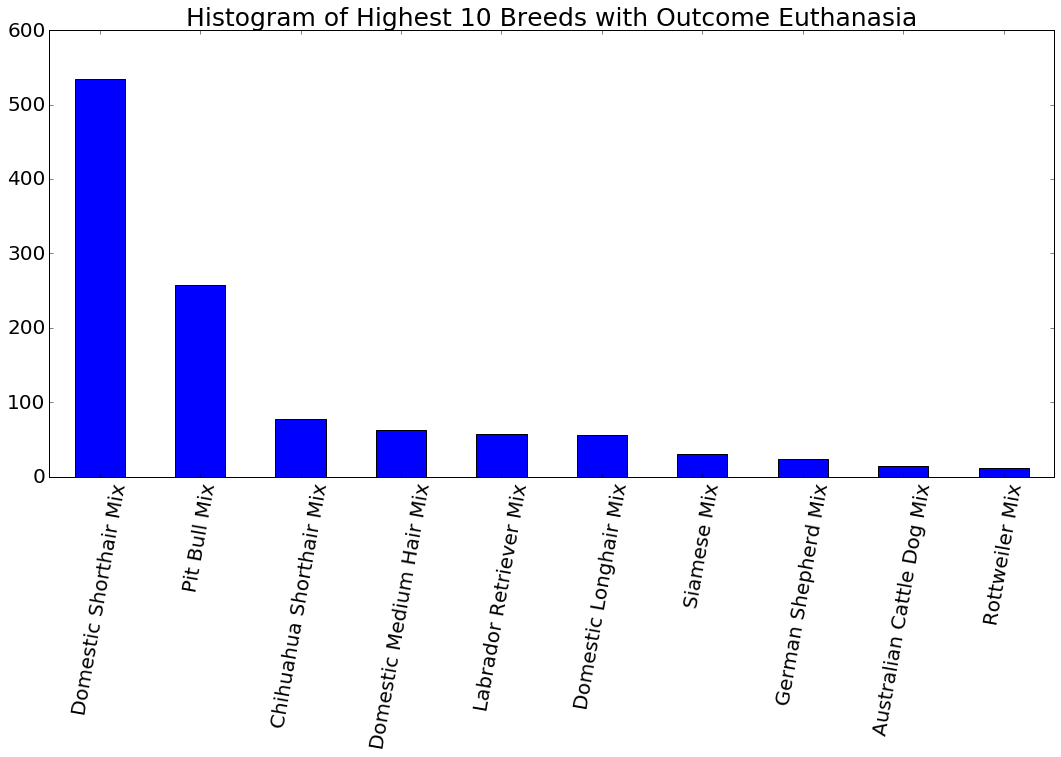

In [616]:
%matplotlib inline
plt.figure(figsize=(18,8))

df_euth['Breed'].value_counts()[0:10].plot(kind = 'bar')
plt.xticks(fontsize = 20, rotation = 80)
plt.yticks(fontsize = 20)
plt.title('Histogram of Highest 10 Breeds with Outcome Euthanasia', fontsize = 25)


In [617]:
df_euth['OutcomeSubtype'].value_counts()

Suffering              1002
Aggressive              320
Behavior                 86
Rabies Risk              74
Medical                  66
Court/Investigation       6
Name: OutcomeSubtype, dtype: int64

#### Most common dog breeds

In [618]:
df[df['AnimalType'] == 'Dog']['Breed'].value_counts()

Pit Bull Mix                                      1906
Chihuahua Shorthair Mix                           1766
Labrador Retriever Mix                            1363
German Shepherd Mix                                575
Australian Cattle Dog Mix                          367
Dachshund Mix                                      318
Boxer Mix                                          245
Miniature Poodle Mix                               233
Border Collie Mix                                  229
Australian Shepherd Mix                            163
Rat Terrier Mix                                    157
Catahoula Mix                                      157
Jack Russell Terrier Mix                           146
Yorkshire Terrier Mix                              143
Chihuahua Longhair Mix                             142
Siberian Husky Mix                                 138
Miniature Schnauzer Mix                            136
Beagle Mix                                         124
Rottweiler

In [619]:
cols = df.columns.values

### Convert Age column to age in years

In [620]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [621]:
df['AgeuponOutcome'].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [622]:
nrows = len(df['AgeuponOutcome'])
Ages = df['AgeuponOutcome'].astype(str)
y = np.zeros((nrows))

for i in range(nrows):
    
    if 'year' in Ages[i]:
        y[i] = (float(Ages[i].split()[0]))
    
    elif 'week' in Ages[i]:
        y[i] = (float(Ages[i].split()[0])/52.)
        
    elif 'month' in Ages[i]:
        y[i] = (float(Ages[i].split()[0])/12.)
        
    elif 'day' in Ages[i]:
        y[i] = (float(Ages[i].split()[0])/352.)
        
    else:
        y[i] = -99 
#     print y[i]

In [623]:
y[y == -99] = np.mean(y[y != -99])

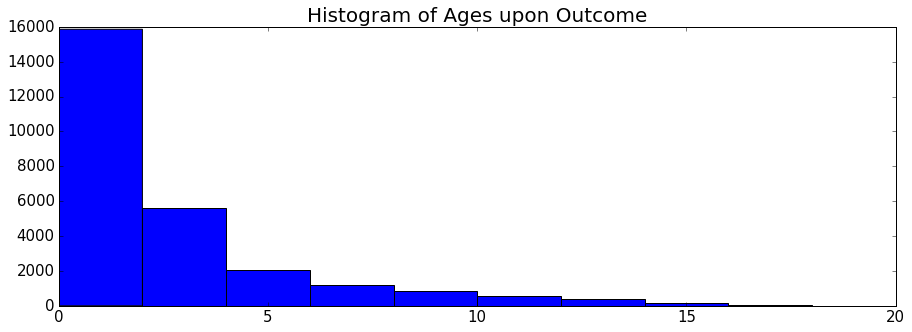

In [624]:
plt.figure(figsize = (15,5))
plt.hist(y)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Histogram of Ages upon Outcome', fontsize = 20)

In [625]:
df['AgeuponOutcome'] = pd.DataFrame({'AgeuponOutcome': y.tolist()})

### Basic Stats for Dogs vs Cats

#### Average age upon Outcome

In [626]:
df[df['AnimalType'] == 'Dog']['AgeuponOutcome'].mean()

2.7590384739991176

In [627]:
df[df['AnimalType'] == 'Cat']['AgeuponOutcome'].mean()

1.3623559083926418

#### Number of dogs vs cats

In [628]:
len(df[df['AnimalType'] == 'Dog'])

15595

In [629]:
len(df[df['AnimalType'] == 'Cat'])

11134

### Create columns for male vs female, fixed vs intact

In [630]:
df['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

In [631]:
df['SexuponOutcome'] = df['SexuponOutcome'].replace(np.nan,'')

In [632]:
spayed_neutered = np.zeros( (len(df['SexuponOutcome']) ))
sex = np.zeros((len(df['SexuponOutcome'])))
for i in range(len(df['SexuponOutcome'])):
#     print df['SexuponOutcome'][i]
    x = df['SexuponOutcome'][i].split()
    if ('Neutered' in x) | ('Spayed' in x):
        spayed_neutered[i] = 1.
    if ('Male' in x):
        sex[i] = 1.
        

In [633]:
np.sum(spayed_neutered)/len(df)

0.69583598338882857

#### Note: Only 69.5% of animals in the shelter are Spayed or Neutered

In [634]:
np.sum(sex)/len(df)

0.49773654083579633

#### About 50% of animals are male

In [635]:
df['Fixed'] = pd.DataFrame({'fixed':spayed_neutered})
df['Male'] = pd.DataFrame({'Male': sex})

df = df.drop('SexuponOutcome',1)

Convert Sex and Neutered Columns

### Look at Animal Color

In [636]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Male
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog Mix,Brown/White,1.0,1.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,1.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull Mix,Blue/White,1.0,1.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,0.0,1.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso/Miniature Poodle,Tan,1.0,1.0


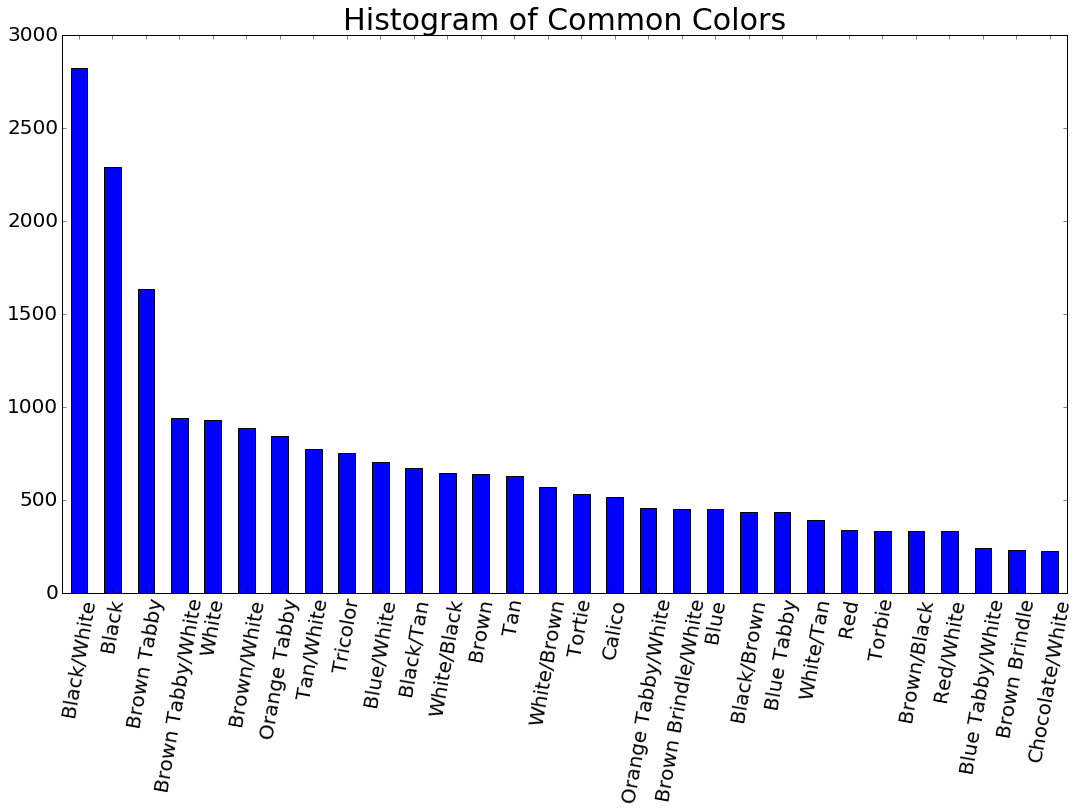

In [637]:
plt.figure(figsize = (18,10))
df['Color'].value_counts()[0:30].plot(kind = 'bar')
plt.xticks(fontsize = 20)
plt.xticks(rotation= 80)
plt.yticks(fontsize = 20)
plt.title('Histogram of Common Colors', fontsize = 30)

In [638]:
df_dogs = df[df['AnimalType'] == 'Dog']

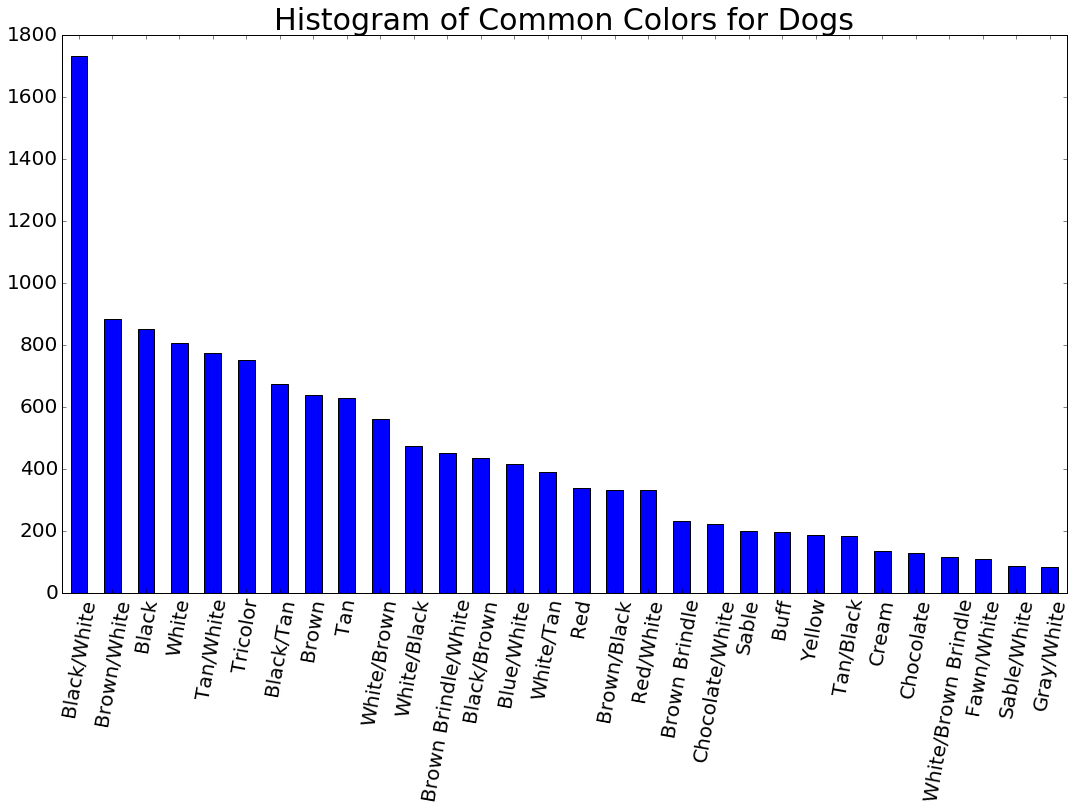

In [639]:
plt.figure(figsize = (18,10))
df_dogs['Color'].value_counts()[0:30].plot(kind = 'bar')
plt.xticks(fontsize = 20)
plt.xticks(rotation= 80)
plt.yticks(fontsize = 20)
plt.title('Histogram of Common Colors for Dogs', fontsize = 30)

### Simplify the Breed and Color Columns

In [640]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Male
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog Mix,Brown/White,1.0,1.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,1.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull Mix,Blue/White,1.0,1.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,0.0,1.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso/Miniature Poodle,Tan,1.0,1.0


In [641]:
len(df['Breed'].unique())

1380

###### Currently, there are 1380 different breed classifications among cats and dogs

In [642]:
df['Breed'].value_counts()[0:10]

Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Name: Breed, dtype: int64

In [643]:
df[df['AnimalType'] == 'Cat']['Breed'].value_counts()[0:10]

Domestic Shorthair Mix      8810
Domestic Medium Hair Mix     839
Domestic Longhair Mix        520
Siamese Mix                  389
Domestic Shorthair           143
Snowshoe Mix                  75
Maine Coon Mix                44
Manx Mix                      44
Domestic Medium Hair          42
Russian Blue Mix              33
Name: Breed, dtype: int64

In [644]:
len(df[df['AnimalType'] == 'Cat']['Breed'].unique())

60

In [645]:
len(df[df['AnimalType'] == 'Dog']['Breed'].unique())

1320

#### Domestic Shorthair Mix seems to be a classification for cats only

- Cat breeds seem to be somewhat limited with 60 different breeds while dogs have 1320 different classifications. We will only simplify dog breeds.

In [646]:
df[df['AnimalType'] == 'Dog']['Breed'].value_counts()[0:20]

Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
German Shepherd Mix           575
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Rat Terrier Mix               157
Catahoula Mix                 157
Jack Russell Terrier Mix      146
Yorkshire Terrier Mix         143
Chihuahua Longhair Mix        142
Siberian Husky Mix            138
Miniature Schnauzer Mix       136
Beagle Mix                    124
Rottweiler Mix                113
American Bulldog Mix          109
Name: Breed, dtype: int64

In [647]:
import re

dog_breeds = list(df[df['AnimalType'] == 'Dog']['Breed'])
for i in range(len(dog_breeds)):
    if ('Mix' in dog_breeds[i]):
        dog_breeds[i] = re.sub(' Mix', '', dog_breeds[i])
    else:
        dog_breeds[i] = dog_breeds[i].split("/")[0]
    
            

###### Let's remove the "Mix" from the dog breeds and also take only the first breed from classifications in the form "breed 1 / breed 2", assuming that the first breed listed is the dominant breed

In [648]:
dog_breeds_df = pd.DataFrame({'Breed':dog_breeds})

In [649]:
len(dog_breeds_df['Breed'].unique())

188

###### We were able to narrow down the different classes of dog breeds from 1320 to 188

In [650]:
dog_breeds_df['Breed'].value_counts()[0:10]

Chihuahua Shorthair      2145
Pit Bull                 2113
Labrador Retriever       1915
German Shepherd           826
Australian Cattle Dog     511
Dachshund                 510
Boxer                     360
Border Collie             334
Miniature Poodle          310
Australian Shepherd       229
Name: Breed, dtype: int64

###### Now let's replace all the dog breed classifications from the original dataframe with the new breed classifications

In [651]:
df.ix[df.AnimalType == 'Dog', 'Breed'] = dog_breeds

In [652]:
len(df['Breed'].unique())

248

###### Now, let's simplify the color Column

In [653]:
len(df['Color'].unique())

366

In [654]:
len(df[df['AnimalType'] == 'Dog']['Color'].unique())

262

### Simplify the date and time column
- Let's divide the dates into seasons of the year

In [655]:
df['DateTime'].head()

0    2014-02-12 18:22:00
1    2013-10-13 12:44:00
2    2015-01-31 12:28:00
3    2014-07-11 19:09:00
4    2013-11-15 12:52:00
Name: DateTime, dtype: object

In [656]:
from datetime import datetime
d = df['DateTime'][0].split()[0]
date = datetime.strptime(d, '%Y-%m-%d')

In [658]:
# season = []
# for i in range(len(df['DateTime'])):
#     d = df['DateTime'][i].split()[0]
#     date = datetime.strptime(d, '%Y-%m-%d')
#     if (date.month >= 11):
#         season.append('Winter')
#     elif (date.month == 1):
#         season.append('Winter')
#     elif (date.month >= 2) & (date.month <= 5):
#         season.append('Spring')
#     elif (date.month >= 6) & (date.month <= 8):
#         season.append('Summer')
#     else:
#         season.append('Fall')
month = []
for i in range(len(df['DateTime'])):
    d = df['DateTime'][i].split()[0]
    date = datetime.strptime(d, '%Y-%m-%d')
    if (date.month == 1):
        month.append('January')
    elif (date.month == 2):
        month.append('February')
    elif (date.month == 3):
        month.append('March')
    elif (date.month == 4):
        month.append('April')
    elif (date.month == 5):
        month.append('May')
    elif (date.month == 6):
        month.append('June')
    elif (date.month == 7):
        month.append('July')
    elif (date.month == 8):
        month.append('August')
    elif (date.month == 9):
        month.append('September')
    elif (date.month == 10):
        month.append('October')
    elif (date.month == 11):
        month.append('November')
    else:
        month.append('December')

In [659]:
df['Month'] = month

In [660]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Breed,Color,Fixed,Male,Month
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,Shetland Sheepdog,Brown/White,1.0,1.0,February
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,Domestic Shorthair Mix,Cream Tabby,1.0,0.0,October
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,Pit Bull,Blue/White,1.0,1.0,January
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,Domestic Shorthair Mix,Blue Cream,0.0,1.0,July
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,Lhasa Apso,Tan,1.0,1.0,November


### Create Dummy Variables for Columns with Categorical Variables

In [661]:
cat_var = ['Color', 'Breed', 'Month']

def dummy(df, list):
    for x in cat_var:
        df1 = pd.get_dummies(df[x])
        df = df.drop(x,axis = 1)
        df = pd.concat([df,df1], axis = 1)
    return df

In [662]:
dat = dummy(df, cat_var)

### Check dimensions of data frame to check dummy function

In [663]:
len(dat.columns.values)

635

In [664]:
len(df.columns.values)

12

In [666]:
len(df['Breed'].unique()) + len(df['Color'].unique()) + len(df['Month'].unique()) - 2 + 11

635

### Create Indicator Column whether the animal was given a name or not

In [667]:
# df['Name'].value_counts(dropna = False)?


In [668]:
dat['Name'] = df['Name'].isnull() * 1.
dat = dat.rename(columns = {'Name':'NoName'})

In [669]:
dat.head()

,AnimalID,NoName,DateTime,OutcomeType,OutcomeSubtype,AnimalType,AgeuponOutcome,Fixed,Male,Agouti,...,December,February,January,July,June,March,May,November,October,September
0,A671945,0.0,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,1.000000,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A656520,0.0,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,1.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,A686464,0.0,2015-01-31 12:28:00,Adoption,Foster,Dog,2.000000,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A683430,1.0,2014-07-11 19:09:00,Transfer,Partner,Cat,0.057692,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A667013,1.0,2013-11-15 12:52:00,Transfer,Partner,Dog,2.000000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Create column for indicator of Animal Type

In [670]:
df['AnimalType'].unique()

array(['Dog', 'Cat'], dtype=object)

In [671]:
dat['AnimalType'] = (df['AnimalType'] == 'Dog') * 1.

### Create Labels

In [672]:
lab = dat['OutcomeType']

In [673]:
len(lab)

26729

In [674]:
# labels = (lab != 'Euthanasia') * 1.

In [675]:
lab.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [676]:
labels = np.zeros(len(lab))
for i in range(len(lab)):
    if lab[i] == 'Adoption':
        labels[i] = 0
    elif lab[i] == 'Transfer':
        labels[i] = 1
    elif lab[i] == 'Return_to_owner':
        labels[i] = 2
    elif lab[i] == 'Euthanasia':
        labels[i] = 3
    else:
        labels[i] = 4

In [677]:
dat.drop(['AnimalID','DateTime','OutcomeType','OutcomeSubtype'],axis = 1).dtypes.unique()

array([dtype('float64')], dtype=object)

In [678]:
dat = dat.drop(['AnimalID','DateTime','OutcomeType','OutcomeSubtype'],axis = 1)

### Create Training and Testing Sets

In [679]:
from sklearn.cross_validation import train_test_split

In [680]:
X_train, X_test, Y_train, Y_test = train_test_split(dat, labels, test_size = 0.30)

In [681]:
len(X_train)/float(len(dat))

0.6999887762355494

In [682]:
from sklearn.preprocessing import normalize

X_train = normalize(X_train, axis = 0)
X_test = normalize(X_test, axis = 0)

### Logistic Regression

In [683]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [684]:
lm = LogisticRegression(penalty = 'l1', multi_class = 'ovr', C = 1.0)
lm.fit(X_train,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [685]:
lm.score(X_test, Y_test)

0.63399426362389322

In [686]:
from sklearn.metrics import log_loss
log_loss(Y_test, lm.predict_proba(X_test))

0.98901530167885643

### Gradient Boosting

In [691]:
from sklearn.ensemble import GradientBoostingClassifier

In [692]:
gb_model = GradientBoostingClassifier(n_estimators = 300)

In [693]:
gb_model.fit(X_train,Y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [694]:
gb_model.score(X_test, Y_test)

0.63199900236937279

### Get important features from Gradient Boosting

In [1]:
# gb_model.feature_importances_

In [696]:
feat_imp = pd.DataFrame({'features':dat.columns.values,'values':gb_model.feature_importances_})

In [698]:
feat_imp.sort('values').iloc[-15:]

/home/truong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,features,values
551,Pit Bull,0.010433
627,May,0.010886
626,March,0.010988
630,September,0.011238
624,July,0.011504
620,August,0.011607
623,January,0.013059
1,AnimalType,0.013785
622,February,0.014541
628,November,0.016689


### Zero Rule Baseline

In [701]:
from scipy import stats
stats.mode(labels)

ModeResult(mode=array([ 0.]), count=array([10769]))

In [702]:
10769./len(labels)

0.40289573122825395